In [ ]:
"""
based on: https://www.kaggle.com/code/zwhjorth/dnn-svm-and-dt-for-fraud-detection
"""

In [ ]:
# Install all requirements needed to train this model and track it in MLFlow.

!pip install -r requirements.txt

In [6]:
# Import the dependencies we need to run the code.

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import tf2onnx
import onnx

In [2]:
# Load the CSV data which we will use to train the model.
# It contains the following fields:
#   distancefromhome - The distance from home where the transaction happened.
#   distancefromlast_transaction - The distance from last transaction happened.
#   ratiotomedianpurchaseprice - Ratio of purchased price compared to median purchase price.
#   repeat_retailer - If it's from a retailer that already has been purchased from before.
#   used_chip - If the (credit card) chip was used.
#   usedpinnumber - If the PIN number was used.
#   online_order - If it was an online order.
#   fraud - If the transaction is fraudulent.

Data = pd.read_csv('data/card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
# Set the input (X) and output (Y) data.
# The only output data we have is if it's fraudulent or not, and all other fields go as inputs to the model.

X = Data.drop(columns = ['fraud'])
y = Data['fraud']

# Split the data into training and testing sets so we have something to test the trained model with.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. This means that the data will be between -1 and 1, which makes it a lot easier for the model to learn than random potentially large values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), we set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [4]:
# Build the model, the model we build here is a simple fully connected deep neural network, containing 3 hidden layers and one output layer.

model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(X.columns)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

Epoch 1/2
20000/20000 [==============================] - 34s 2ms/step - loss: 0.0931 - accuracy: 0.9605 - val_loss: 0.1205 - val_accuracy: 0.9528
Epoch 2/2
6250/6250 [==============================] - 5s 775us/step


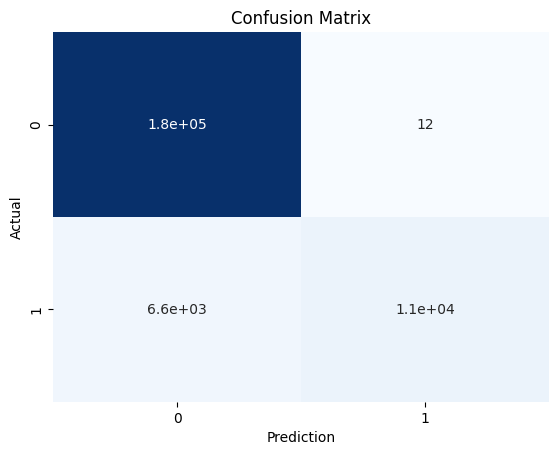

NameError: name 'tf2onnx' is not defined

In [5]:
# Train the model and get performance

epochs = 2
history = model.fit(X_train, y_train, epochs=epochs, \
                    validation_data=(scaler.transform(X_val),y_val), \
                    verbose = True, class_weight = class_weights)

y_pred_temp = model.predict(scaler.transform(X_test))

threshold = 0.995

y_pred = np.where(y_pred_temp > threshold, 1,0)
c_matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(c_matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

model_proto,_ = tf2onnx.convert.from_keras(model)
onnx.save(model_proto, )

In [8]:
model_proto,_ = tf2onnx.convert.from_keras(model)
onnx.save(model_proto, "model.onnx")

In [ ]:
! curl -X POST -k https://credit-fraud-robert-serving-test.apps.rhods-internal.61tk.p1.openshiftapps.com/v2/models/credit-fraud/infer -d '{"inputs": [{ "name": "dense_input", "shape": [1, 7], "datatype": "FP32", "data": [57.87785658389723,0.3111400080477545,1.9459399775518593,1.0,1.0,0.0,0.0]}]}'

In [ ]:
%%bash

#URL="https://credit-fraud-robert-serving-test.apps.rhods-internal.61tk.p1.openshiftapps.com/v2/models/credit-fraud/infer"
URL="https://model1-a-great-project.apps.rhods-internal.61tk.p1.openshiftapps.com/v2/models/model1/infer"

curl -s -X POST -k ${URL} \
    -d '{"inputs":
    [{ "name": "dense_input",
      "shape": [1, 5],
      "datatype": "FP32",
      "data": [57.87785658389723,
               1.94,
               1.0,
               0.0,
               0.0]}]}' \
    | jq